In [1]:
%load_ext autoreload
%autoreload 2

import torch
from circuits_benchmark.utils.get_cases import get_cases
import iit.model_pairs as mp
from circuits_benchmark.utils.ll_model_loader.ll_model_loader_factory import get_ll_model_loader
from circuits_benchmark.benchmark.benchmark_case import BenchmarkCase
from circuits_benchmark.utils.circuit.circuit_eval import calculate_fpr_and_tpr, build_from_acdc_correspondence
from circuits_benchmark.utils.circuit.circuit import Circuit
from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from circuits_benchmark.utils.iit.correspondence import TracrCorrespondence
from huggingface_hub import hf_hub_download
import sys
import pickle
import os
from circuits_benchmark.utils.iit._acdc_utils import get_gt_circuit
from functools import partial
from circuits_benchmark.commands.algorithms.acdc import ACDCRunner, ACDCConfig
from circuits_benchmark.commands.algorithms.eap import EAPRunner, EAPConfig
from circuits_benchmark.commands.algorithms.legacy_acdc import LegacyACDCRunner

In [8]:

def get_acdc_runner(task, threshold, abs_threshold=True):
    config = ACDCConfig(threshold=threshold, abs_value_threshold=abs_threshold)
    acdc_runner = ACDCRunner(task, config=config)
    return acdc_runner

def get_legacy_acdc_runner(task, threshold):
    config = ACDCConfig(threshold=threshold)
    acdc_runner = LegacyACDCRunner(task, config=config)
    return acdc_runner

def get_eap_runner(task, threshold, integrated_grad_steps=10, normalize_scores=False, abs_threshold=True):
    config = EAPConfig(
        threshold=threshold, 
        normalize_scores=normalize_scores,
        integrated_grad_steps=integrated_grad_steps,
        abs_value_threshold=abs_threshold
    )
    eap_runner = EAPRunner(task, config=config)
    return eap_runner


def run(runner, is_categorical: bool, tl_model, task):
    # Prepare data
    data_size = runner.config.data_size
    clean_dataset = task.get_clean_data(max_samples=data_size)
    corrupted_dataset = task.get_corrupted_data(max_samples=data_size)
    clean_inputs, clean_outputs = (
        clean_dataset.get_inputs(),
        clean_dataset.get_targets(),
    )
    corrupted_inputs, corrupted_outputs = (
        corrupted_dataset.get_inputs(),
        corrupted_dataset.get_targets(),
    )
    # if categorical:
    #     clean_outputs = clean_outputs.argmax(dim=-1)
    #     clean_outputs = torch.nn.functional.one_hot(clean_outputs, num_classes=model.cfg.d_vocab_out)[:, 1:, :]
    #     corrupted_outputs = corrupted_outputs.argmax(dim=-1)
    #     corrupted_outputs = torch.nn.functional.one_hot(corrupted_outputs, num_classes=model.cfg.d_vocab_out)[:, 1:, :]
    kwargs = (
        {
            "faithfulness_metric": "mse" if not is_categorical else "kl_div"
        } if isinstance(runner, ACDCRunner) else {}
    )
    circuit = runner.run(
        tl_model=tl_model,
        clean_inputs=clean_inputs,
        clean_outputs=clean_outputs,
        corrupted_inputs=corrupted_inputs,
        corrupted_outputs=corrupted_outputs,
        **kwargs
    )
    return circuit

def run_circuit_discovery_methods(
    runner_classes: list[callable],
    runner_labels: list[str],
    thresholds: list[float],
    task: BenchmarkCase,
    tl_model: torch.nn.Module
):
    runner_results = {}
    for t in thresholds:
        runners = [runner_class(threshold=t) for runner_class in runner_classes]
        for runner, label in zip(runners, runner_labels):
            print(f"Running {label} for threshold {t}")
            circuit = run(runner, is_categorical=task.is_categorical(), tl_model=tl_model, task=task)
            runner_results.setdefault(label, []).append(circuit)
    return runner_results

In [3]:
def make_gt_and_full_circuits(task: BenchmarkCase, model_pair: mp.BaseModelPair):
    model = model_pair.ll_model
    full_corr = TLACDCCorrespondence.setup_from_model(model, use_pos_embed=True)
    full_circuit = build_from_acdc_correspondence(corr=full_corr)
    n_heads = model.cfg.n_heads
    return get_gt_circuit(
        hl_ll_corr=model_pair.corr,
        full_circuit=full_circuit,
        n_heads=n_heads, 
        case=task), full_circuit

def get_curves(list_of_results: list[list], nodes = True) -> list[tuple[list[float], list[float]]]:
    curves = []
    for results in list_of_results:
        if nodes:
            tprs = [r.nodes.tpr for r in results]
            fprs = [r.nodes.fpr for r in results]
        else:
            tprs = [r.edges.tpr for r in results]
            fprs = [r.edges.fpr for r in results]
        curves.append((fprs, tprs))
    return curves

In [4]:
from interp_utils.circuit_discovery.pessimistic_roc import pessimistic_roc
import matplotlib.pyplot as plt
def plot_curves(node_curves, edge_curves, labels, task_idx):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    pessimistic_roc(node_curves, labels=labels, ax=ax[0])
    pessimistic_roc(edge_curves, labels=labels, ax=ax[1])
    ax[0].set_title(f"Node ROC for task {task_idx}")
    ax[1].set_title(f"Edge ROC for task {task_idx}")
    # make legend outside of plot
    ax[0].legend(loc='upper left', bbox_to_anchor=(0, -0.1))
    ax[1].legend(loc='upper left', bbox_to_anchor=(0, -0.1))
    fig.savefig(f"interp_results/{task_idx}/roc_tracr_vs_interp_bench.pdf", bbox_inches='tight')

In [9]:
task_idx = '11'
os.makedirs(f'interp_results/{task_idx}', exist_ok=True)

task: BenchmarkCase = get_cases(indices=[task_idx])[0]

ll_model_loader = get_ll_model_loader(task, interp_bench=True)
hl_ll_corr, model = ll_model_loader.load_ll_model_and_correspondence(device='cuda' if torch.cuda.is_available() else 'cpu')
# turn off grads
# model.eval()
model.requires_grad_(False)

hl_model = task.get_hl_model()
model_pair = mp.StrictIITModelPair(hl_model, model, hl_ll_corr)
tracr_model_pair = mp.StrictIITModelPair(hl_model, hl_model, TracrCorrespondence.make_identity_corr(task.get_tracr_output()))

{'hook_embed': HookPoint(), 'hook_pos_embed': HookPoint(), 'blocks.0.attn.hook_k': HookPoint(), 'blocks.0.attn.hook_q': HookPoint(), 'blocks.0.attn.hook_v': HookPoint(), 'blocks.0.attn.hook_z': HookPoint(), 'blocks.0.attn.hook_attn_scores': HookPoint(), 'blocks.0.attn.hook_pattern': HookPoint(), 'blocks.0.attn.hook_result': HookPoint(), 'blocks.0.mlp.hook_pre': HookPoint(), 'blocks.0.mlp.hook_post': HookPoint(), 'blocks.0.hook_attn_in': HookPoint(), 'blocks.0.hook_q_input': HookPoint(), 'blocks.0.hook_k_input': HookPoint(), 'blocks.0.hook_v_input': HookPoint(), 'blocks.0.hook_mlp_in': HookPoint(), 'blocks.0.hook_attn_out': HookPoint(), 'blocks.0.hook_mlp_out': HookPoint(), 'blocks.0.hook_resid_pre': HookPoint(), 'blocks.0.hook_resid_mid': HookPoint(), 'blocks.0.hook_resid_post': HookPoint(), 'blocks.1.attn.hook_k': HookPoint(), 'blocks.1.attn.hook_q': HookPoint(), 'blocks.1.attn.hook_v': HookPoint(), 'blocks.1.attn.hook_z': HookPoint(), 'blocks.1.attn.hook_attn_scores': HookPoint(), 'b

In [10]:
%%capture
thresholds = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 0.025, 0.05, 0.1, 0.2, 0.5, 0.8, 1.0, 10.0, 20.0, 50.0, 100.0]
runner_classes = [
    partial(get_acdc_runner, task=task),
]
runner_labels = [
    "ACDC",
]

runner_circuits = run_circuit_discovery_methods(runner_classes, runner_labels, thresholds, task, tl_model=model)
tracr_runner_circuits = run_circuit_discovery_methods(runner_classes, runner_labels, thresholds, task, tl_model=hl_model)

In [11]:
SIIT_vs_TRACR_results = {}
gt_circuit, full_circuit = make_gt_and_full_circuits(task, model_pair)
for k, results in runner_circuits.items():
    results = [calculate_fpr_and_tpr(circuit, gt_circuit, full_circuit, print_summary=False) for circuit in results]
    key = k + "(SIIT)"
    SIIT_vs_TRACR_results[key] = results

tracr_gt_circuit, tracr_full_circuit = make_gt_and_full_circuits(task, tracr_model_pair)
for k, results in tracr_runner_circuits.items():
    results = [calculate_fpr_and_tpr(circuit, tracr_gt_circuit, tracr_full_circuit, print_summary=False) for circuit in results]
    key = k + "(TRACR)"
    SIIT_vs_TRACR_results[key] = results

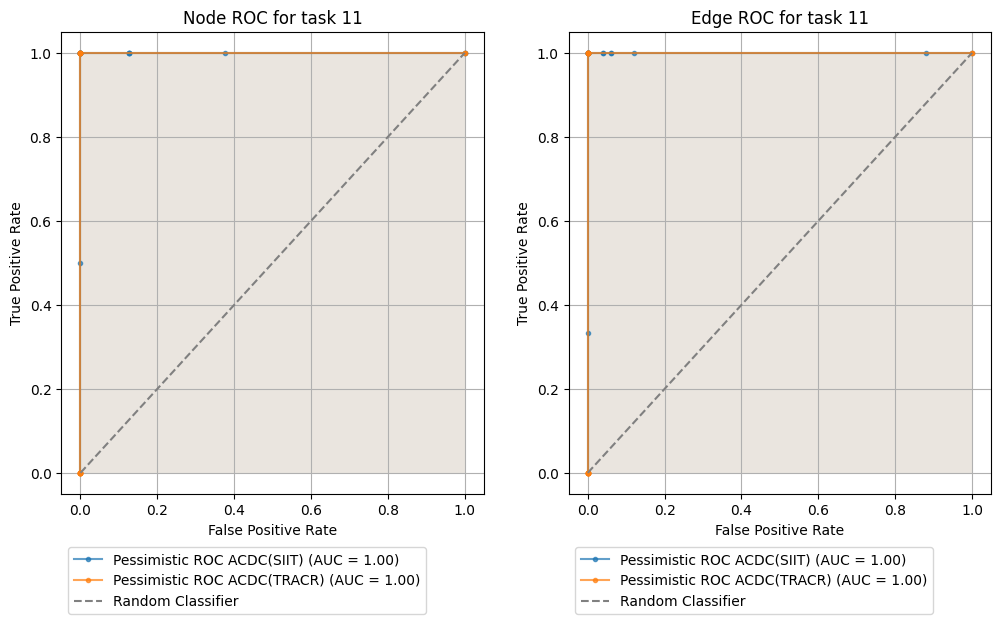

In [12]:
node_curves = get_curves(list(SIIT_vs_TRACR_results.values()), nodes=True)
edge_curves = get_curves(list(SIIT_vs_TRACR_results.values()), nodes=False)
plot_curves(
    node_curves, 
    edge_curves,
    list(SIIT_vs_TRACR_results.keys()),
    task_idx
)

In [13]:
from interp_utils.circuit_discovery.pessimistic_roc import pessimistic_auc
node_curve_dict = dict(zip(SIIT_vs_TRACR_results.keys(), node_curves))
edge_curve_dict = dict(zip(SIIT_vs_TRACR_results.keys(), edge_curves))

aucs = {}
aucs["task_name"] = task_idx
for k, (fprs, tprs) in node_curve_dict.items():
    auc = pessimistic_auc(fprs, tprs)
    aucs[k + "nodes AUC"] = auc

for k, (fprs, tprs) in edge_curve_dict.items():
    auc = pessimistic_auc(fprs, tprs)
    aucs[k + "edges AUC"] = auc
auc

In [14]:
# import pandas as pd
# def append_row(table, row):
#     return pd.concat([
#                 table, 
#                 pd.DataFrame([row], columns=row.index)]
#         ).reset_index(drop=True)

# auc_row = pd.Series(aucs)
# auc_df = pd.DataFrame([auc_row])
# csv_of_all_tasks = f"interp_results/siit_vs_tracr.csv"
# if os.path.exists(csv_of_all_tasks):
#     df = pd.read_csv(csv_of_all_tasks)
#     if task_idx not in [str(v) for v in df.task_name.values]:
#         df = append_row(df, auc_row)
# else:
#     df = auc_df

# df.to_csv(csv_of_all_tasks, index=False)

(0.0, 1.0)

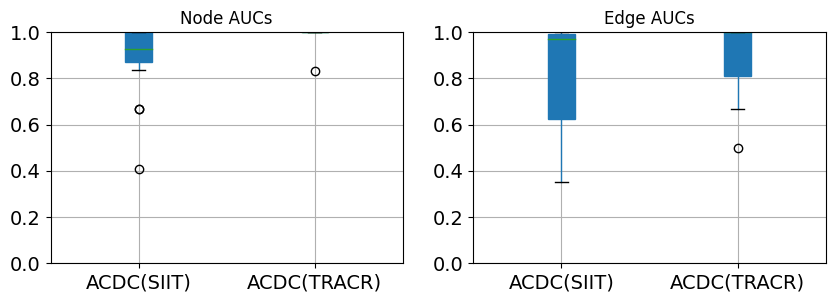

In [118]:
import pandas as pd

df = pd.read_csv("interp_results/siit_vs_tracr.csv")

# plot AUCs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
node_cols = [col for col in df.columns if "nodes" in col]
edge_cols = [col for col in df.columns if "edges" in col]

df.boxplot(
    ax=ax[0],
    column=node_cols,
    patch_artist=True,
    showfliers=True,
    # whis=[5, 95],
)
df.boxplot(
    ax=ax[1],
    column=edge_cols,
    patch_artist=True,
    showfliers=True,
    # whis=[5, 95],
)
ax[0].set_title("Node AUCs")
ax[1].set_title("Edge AUCs")
ax[0].set_xticklabels([col.replace("nodes AUC", "") for col in node_cols])
ax[1].set_xticklabels([col.replace("edges AUC", "") for col in edge_cols])
# font size
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

# set bounds 0-1
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
# plt.tight_layout()

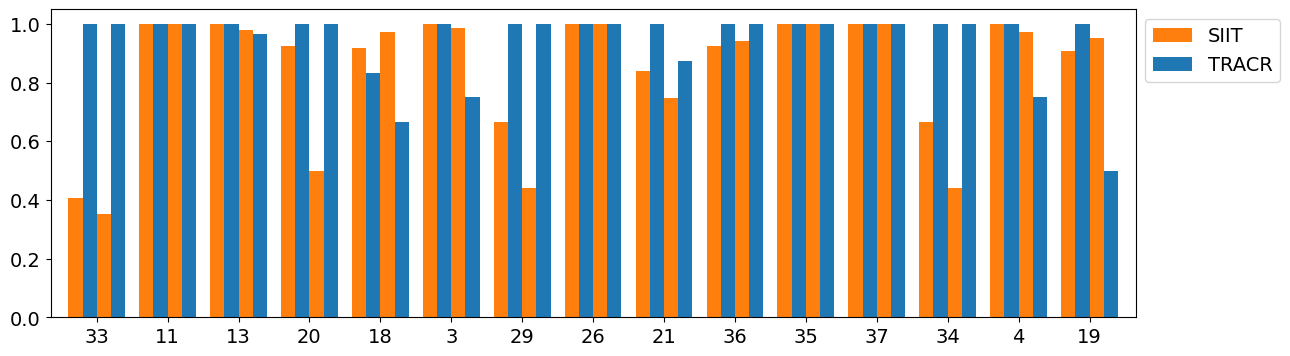

In [173]:
df = pd.read_csv("interp_results/siit_vs_tracr.csv")
# bar plot of df, with 2 colors for SIIT and TRACR respectively
cmap = plt.get_cmap('viridis')
c0 = 'C0'#cmap(0.15)
c1 = 'C1'#cmap(0.92)
df.plot(kind='bar', y=[col for col in df.columns if "AUC" in col], 
        color=[
            c0 if "SIIT" in col else c1 for col in df.columns.to_list()
        ],
        position=0.5, width=0.8)

# set figure size
fig = plt.gcf()
fig.set_size_inches(14, 4)

# set xticks as task names
plt.xticks(range(len(df)), df.task_name, rotation=0)

# font size
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
# legend outside of plot
plt.legend(["SIIT", "TRACR"], fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig("interp_results/siit_vs_tracr_auc_barplot.pdf", bbox_inches='tight')

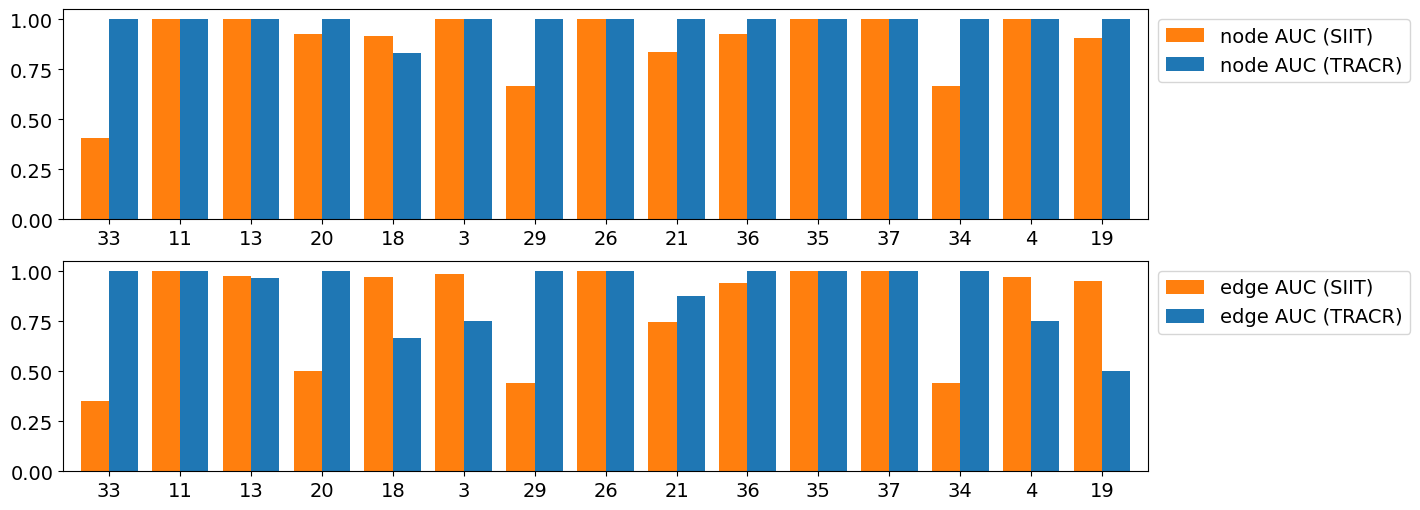

In [191]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6))

cmap = plt.get_cmap('viridis')
c0 = 'C0'#cmap(0.15)
c1 = 'C1'#cmap(0.92)
df.plot(kind='bar', y=[col for col in df.columns if "node" in col], 
        color=[
            c0 if "SIIT" in col else c1 for col in df.columns.to_list()
        ],
        position=0.5, width=0.8, ax=ax[0])

df.plot(kind='bar', y=[col for col in df.columns if "edge" in col],
        color=[
            c0 if "SIIT" in col else c1 for col in df.columns.to_list()
        ],
        position=0.5, width=0.8, ax=ax[1])

# set xticks as task names
# plt.xticks(range(len(df)), df.task_name, rotation=0)
ax[0].set_xticks(range(len(df)))
ax[0].set_xticklabels(df.task_name, rotation=0)
ax[1].set_xticks(range(len(df)))
ax[1].set_xticklabels(df.task_name, rotation=0)

# font size
# plt.tick_params(axis='x', labelsize=14)
# plt.tick_params(axis='y', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)
ax[0].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='x', labelsize=14)

# legend outside of plot
ax[0].legend(["node AUC (SIIT)", "node AUC (TRACR)"], fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
ax[1].legend(["edge AUC (SIIT)", "edge AUC (TRACR)"], fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

# plt.legend(["SIIT", "TRACR"], fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig("interp_results/siit_vs_tracr_auc_two_barplots.pdf", bbox_inches='tight')


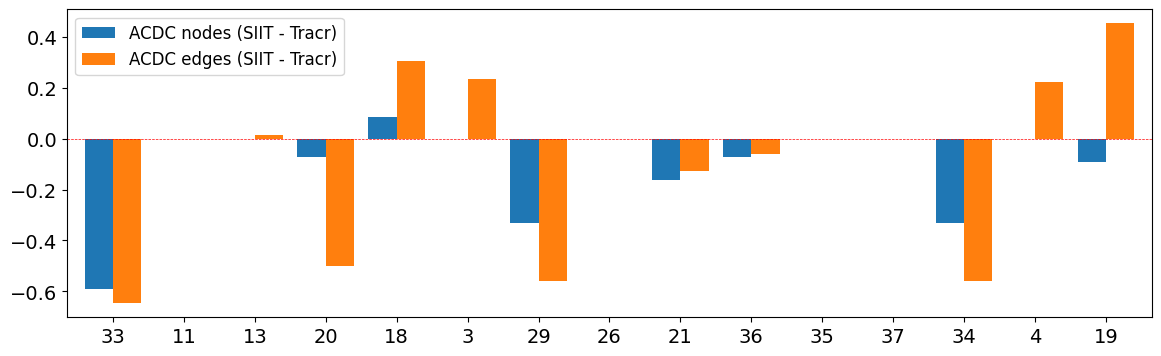

In [180]:
diff_nodes = pd.DataFrame()
for col in siit_nodes_cols:
    col_name = col.replace("(SIIT)", " ").replace("AUC", "") + "(SIIT - Tracr)"
    diff_nodes[col_name] = df[col] - df[col.replace("SIIT", "TRACR")]

diff_edges = pd.DataFrame()
for col in siit_edges_cols:
    col_name = col.replace("(SIIT)", " ").replace("AUC", "") + "(SIIT - Tracr)"
    diff_edges[col_name] = df[col] - df[col.replace("SIIT", "TRACR")]

# combine the two dataframes
diff_df = pd.concat([diff_nodes, diff_edges], axis=1)
diff_df["task_name"] = df.task_name

# bar plot of df, with 2 colors for nodes and edges respectively
cmap = plt.get_cmap('viridis')
c0 = 'C0'
c1 = 'C1'
diff_df.plot(kind='bar', y=[col for col in diff_df.columns if "task" not in col], 
        color=[
            c0 if "nodes" in col else c1 for col in diff_df.columns.to_list()
        ],
        position=0.5, width=0.8)

# set xticks as task names
plt.xticks(range(len(diff_df)), 
              diff_df.task_name,
           rotation=0)
# set figure size
fig = plt.gcf()
fig.set_size_inches(14, 4)

# font size
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
# legend font size
plt.legend(fontsize=12)

# plot 0 line
plt.axhline(0, color='red', linestyle='--', linewidth=0.5)

plt.savefig("interp_results/siit_vs_tracr_auc_diff_barplot.pdf", bbox_inches='tight')

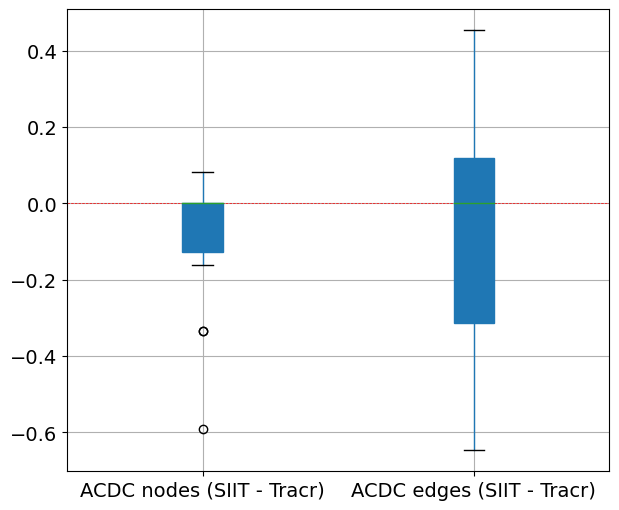

In [184]:
diff_df.boxplot(
    column=[col for col in diff_df.columns if "task" not in col],
    patch_artist=True,
    showfliers=True,
    # whis=[5, 95],
)
# set figure size
fig = plt.gcf()
fig.set_size_inches(7, 6)
# plot 0 line
plt.axhline(0, color='red', linestyle='--', linewidth=0.5)

# font size
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=14)
plt.savefig("interp_results/siit_vs_tracr_auc_diff_boxplot.pdf", bbox_inches='tight')